In [1]:
%matplotlib inline
import numpy as np
import yt
from yt.fields.derived_field import ValidateSpatial
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [258]:
#
# Test out the chemical abundance stuff here 
#

NBINS = 15 + 1

binstart = np.log10(1.0)
binend   = np.log10(1400.0)

bins     = np.logspace(binstart, binend, NBINS)[:-1]
db       = bins[1:] - bins[:-1]
db[0]    = bins[1] - 0.0
print(bins)


#sne_O = 1.17 * yt.units.Msun

#age_bin_zero = (db[0]) * yt.units.Myr # 0.1 to 1.0 Myr
#RSNe = 3.0E-4 / yt.units.Myr # SNe / Myr / solar mass 

#O_bin_zero  = age_bin_zero * RSNe * sne_O
#O_bin_one   = db[1] * yt.units.Myr * RSNe
#print(O_bin_zero, O_bin_one)

#O_bin_three = ((10.37 - db[3])*5.408E-4 + (db[4]-10.37)*2.516E-4) * sne_O
#print(O_bin_three)

[  1.           1.62084643   2.62714315   4.2581956    6.90188115
  11.18688942  18.13222979  29.38955994  47.63596334  77.21058117
 125.14649491 202.84324963 328.7777572  532.89825434 863.74623361]


In [259]:
elements = ['Total','He','C','N','O','Ne','Mg','Si','S','Ca','Fe']

element_num = {}
i = 0
for e in elements:
    element_num[e] = i
    i = i + 1

def sn_rate(t):
    # SN / Gyr  per solar msas of star formation
    #    Changed output to /Gyr to keep same units as input t
    
    agemin = 0.003401   # Gyr
    agebrk = 0.010370   # Gyr
    agemax = 0.03753    # Gyr
    
    RSNE = 0.0
    if (t>agemin):
        if (t <= agebrk):
            RSNE = 5.408E-4
        elif (t<=agemax):
            RSNE=2.516E-4
        
        if (t > agemax):
            RSNE=5.3E-8+1.6*np.exp(-0.5*((t-0.05)/0.01)*((t-0.05)/0.01)) # This is JUST SNIa
            RSNE=0.0 # set to zero
            
    return RSNE * 1000.0

def snIa_rate(t):
    agemin = 0.003401   # Gyr
    agebrk = 0.010370   # Gyr
    agemax = 0.03753    # Gyr
    
    RSNE = 0.0
    if (t > agemax):
        RSNE=5.3E-8+1.6E-5*np.exp(-0.5*((t-0.05)/0.01)*((t-0.05)/0.01)) # This is JUST SNIa
            
    return RSNE * 1000.0

#def wind_rate(t):

def wind_yields(i,element=None):
    yields = [0.0, 0.36,0.016,0.0041,0.0118] + [0.0]*6
    yields[0] = np.sum(yields[1:])
    # if element passed, use that - otherwise use yield indeces
    if not (element is None):
        if element == 'all':
            return yields

    return yields[i]

def wind_rate(t, Z = 1.0, GasReturnFraction = 1.0):
    
    p = 0.0
    if (t <= 0.001):
        p = 11.6846
    else:
        if (t <=0.0035):
            logZ=np.log10(Z)
            p=11.6846*Z*10.0**(1.838*(0.79+logZ)*(np.log10(t)-(-3.00)))
        else:
            if (t<=0.1):
                p=72.1215*(t/0.0035)**(-3.25)+0.0103
            else:
                p=1.03*t**(-1.1) / (12.9-np.log10(t))
                
    #p = 1.0 - np.exp(-p)
    
    #if (t < 0.1):
    #    p = p * 1.0
    
    # assuming wind_rate is in Msun / Myr per solar mass of SF
    
    wind_rate = p * GasReturnFraction * 1.4 * 0.291175
    
    return wind_rate # might already be / Gyr

def snIa_yields(i, element = None):
    yields = [1.4,0.0,0.049,1.2E-6,0.143,0.0045,0.0086,0.156,0.087,0.012,0.743]
    
    # if element passed, use that - otherwise use yield indeces
    if not (element is None):
        if element == 'all':
            return yields

    return yields[i]
    
def snII_yields(i, element = None):
    # if element passed, use that - otherwise use yield indeces
    
    yields = [2.0,3.87,0.133,0.0479,1.17,0.30,0.0987,0.0933,0.0397,0.00458,0.0741]

    if not (element is None):
        if element == 'all':
            return yields
        
        i = element_num[element]
    

    return yields[i]    

def construct_yields(agebins, yieldtype = 'total'):

    points = [0.003401, 0.010370, 0.03753]
    
    yields = np.zeros( (np.size(agebins), np.size(elements))) 
    
    print( np.shape(yields))
    
    if yieldtype == 'snII' or yieldtype == 'total' or yieldtype == 'sn_only':
        numsnII = np.zeros(np.size(agebins))
        
        for i in np.arange(np.size(agebins) - 1):
            
            if i == 0:
                mint = 0.0
            else:
                mint = agebins[i]
            maxt = agebins[i+1]
            numsnII[i] = integrate.quad( sn_rate, mint, maxt, points = points)[0]
            
        numsnII[-1] = integrate.quad(sn_rate, agebins[-1], 14.0, points = points)[0]  
        
        print(numsnII)
        
        yields += np.outer(numsnII, snII_yields(-1, element = 'all'))
    
    if yieldtype == 'snIa' or yieldtype == 'total' or yieldtype == 'sn_only':    
        numsnIa = np.zeros(np.size(agebins))
        
        for i in np.arange(np.size(agebins) - 1 ):
            
            if i == 0:
                mint = 0.0
            else:
                mint = agebins[i]
            maxt = agebins[i+1]
            numsnIa[i] = integrate.quad( snIa_rate, mint, maxt, points = points)[0]
        numsnIa[-1] = integrate.quad(snIa_rate, agebins[-1], 14.2, points = points)[0]
        
        yields += np.outer(numsnIa, snIa_yields(-1, element = 'all'))        
 
    if yieldtype == 'winds' or yieldtype == 'total':    
        wind_mass  = np.zeros(np.size(agebins))
        windpoints = [0.001, 0.0035, 0.1]
        
        for i in np.arange(np.size(agebins) - 1 ):
            
            if i == 0:
                mint = 0.0
            else:
                mint = agebins[i]
            maxt         = agebins[i+1]
            wind_mass[i] = integrate.quad(wind_rate, mint, maxt, points = windpoints)[0]
        wind_mass[-1]      = integrate.quad(wind_rate, agebins[-1], 14.2, points = windpoints)[0]
        
        yields += np.outer(wind_mass, wind_yields(-1, element = 'all'))  
        
    return yields


In [260]:
total_yield_masses = construct_yields(bins/1000.0, yieldtype = 'total')
print(bins)
print(total_yield_masses[:,4])

(15, 11)
[0.         0.         0.00046357 0.00142971 0.00208109 0.00174745
 0.00283234 0.00204813 0.         0.         0.         0.
 0.         0.         0.        ]
[  1.           1.62084643   2.62714315   4.2581956    6.90188115
  11.18688942  18.13222979  29.38955994  47.63596334  77.21058117
 125.14649491 202.84324963 328.7777572  532.89825434 863.74623361]
[1.08194251e-04 1.69903196e-04 9.84785227e-04 1.90292107e-03
 2.51268767e-03 2.07103700e-03 3.32323208e-03 2.41750375e-03
 3.65426782e-05 1.01790460e-04 2.10506613e-04 2.04085482e-04
 1.98158290e-04 1.92855748e-04 1.09324879e-03]


[0.       0.294372 0.632736]
0.019236588228


(0.0, 0.05)

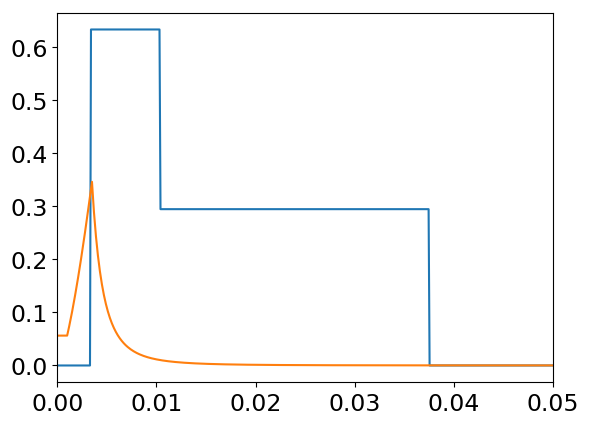

In [261]:
t = np.linspace(0.0, 0.1, 1000)
y = np.array([sn_rate(x) for x in t]) * 1.17

print(np.unique(y))

print(0.294372 * (0.010370 - 0.003401) + 0.632736 * (0.03753 - 0.010370))

plt.plot(t,y)
y = np.array([wind_rate(x) for x in t]) * 0.0118
plt.plot(t,y)
plt.xlim(0.0, 0.050)
#print(y)

In [262]:

def generate_metal_fields(ds, _agebins=bins, 
                              _elements=elements,
                              _yields=total_yield_masses,
                              ptype='PartType0'):
    
    offset = 15 
    #ptype = 'PartType0'
    
    def _metal_mass_test(_ptype, _ei):
        # test metals in bin zero 
    
        def temp(field,data):
            mass_p = np.zeros(np.shape( data[(_ptype,'particle_mass')]))
            for i in np.arange(np.size(_agebins)):
                fname    = 'Metallicity_%02i'%(offset + i)
                mass_p += data[(ptype,fname)].value * _yields[i,_ei] #(agebinnum,  elementnum)
            
            mass_p = mass_p * yt.units.Msun
          
            return mass_p
        
        return temp
    
    def _metal_fraction_test(_ptype, _e):
        def temp(field,data):
            Mp    = data[(_ptype,'particle_mass')].to('Msun')
            abund = data[('all',_ptype + '_' + _e + '_mass')].to('Msun') / Mp
            abund[Mp==0.0] = 0.0
            return abund
        return temp
    
    def _metal_mass_actual_test(_ptype,_ei):
        def temp(field,data):
            Mp    = data[(_ptype,'particle_mass')].to('Msun')
            abund = data[(_ptype,"Metallicity_%02i"%(_ei))]
        
            
            return abund*Mp
        return temp
            
    
    
    for ei,e in enumerate(_elements):

        ds.add_field( ('all', ptype + '_' + e + '_mass'), sampling_type='particle', 
                      function=_metal_mass_test(ptype, ei),
                      units = 'Msun', force_override=True)
        ds.add_field(  ('all',ptype + '_' + e + '_fraction'), sampling_type='particle',
                      function=_metal_fraction_test(ptype,e),
                      units='', force_override=True)
        
        ds.add_field( ('all',ptype + '_' + e + '_actual_mass'), sampling_type='particle',
                       function=_metal_mass_actual_test(ptype,ei),
                       units='Msun', force_override=True)
        
    return    

def _generate_star_metal_fields(ds,
                                _agebins=bins, 
                                _elements=elements,
                                _yields=total_yield_masses,
                                ptype='PartType4'):
    
    offset = 15
    
    def _star_metal_mass_test(_ptype, _ei):
        # test metals in bin zero 
    
        def temp(field,data):
            mass_p = np.zeros(np.shape( data[(_ptype,'particle_mass')]))
            for i in np.arange(np.size(_agebins)):
                fname    = 'Metallicity_%02i'%(offset + i)
                mass_p += data[(ptype,fname)].value * _yields[i,_ei] #(agebinnum,  elementnum)
            
            mass_p = mass_p * yt.units.Msun
          
            return mass_p
        
        return temp
    
        
    for ei,e in enumerate(_elements):

        ds.add_field( ('all', ptype + '_' + e + '_mass'), sampling_type='particle', 
                      function=_star_metal_mass_test(ptype, ei),
                      units = 'Msun', force_override=True)
        
    return

In [263]:
print(bins)

[  1.           1.62084643   2.62714315   4.2581956    6.90188115
  11.18688942  18.13222979  29.38955994  47.63596334  77.21058117
 125.14649491 202.84324963 328.7777572  532.89825434 863.74623361]


In [264]:
ds0    = yt.load('./testtwo/snapshot_000.hdf5')
data0   = ds0.all_data()
generate_metal_fields(ds0)

mtrue_initial = {}
for e in elements:
    m = data0[('all','PartType0_'+e+'_actual_mass')]
    mtrue_initial[e] = np.sum( m ).to('Msun')
    
print(mtrue_initial)

yt : [INFO     ] 2019-08-27 17:50:31,137 Calculating time from 0.000e+00 to be 3.063e+17 seconds
yt : [INFO     ] 2019-08-27 17:50:31,138 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2019-08-27 17:50:31,160 Parameters: current_time              = 3.063114274545048e+17 s
yt : [INFO     ] 2019-08-27 17:50:31,161 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-08-27 17:50:31,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-08-27 17:50:31,163 Parameters: domain_right_edge         = [10000. 10000. 10000.]
yt : [INFO     ] 2019-08-27 17:50:31,164 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-08-27 17:50:31,165 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2019-08-27 17:50:31,166 Parameters: omega_lambda              = 0.73
yt : [INFO     ] 2019-08-27 17:50:31,166 Parameters: omega_matter              = 0.27
yt : [INFO     ] 2019-08-27 17:50:31,167 Parameters: omega_radiation           = 0.0
y

{'Total': 0.0 Msun, 'He': 2249999988.6349545 Msun, 'C': 0.0 Msun, 'N': 0.0 Msun, 'O': 0.0 Msun, 'Ne': 0.0 Msun, 'Mg': 0.0 Msun, 'Si': 0.0 Msun, 'S': 0.0 Msun, 'Ca': 0.0 Msun, 'Fe': 0.0 Msun}


In [265]:
ds0.field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metallicity_01'),
 ('PartType0', 'Metallicity_02'),
 ('PartType0', 'Metallicity_03'),
 ('PartType0', 'Metallicity_04'),
 ('PartType0', 'Metallicity_05'),
 ('PartType0', 'Metallicity_06'),
 ('PartType0', 'Metallicity_07'),
 ('PartType0', 'Metallicity_08'),
 ('PartType0', 'Metallicity_09'),
 ('PartType0', 'Metallicity_10'),
 ('PartType0', 'Metallicity_11'),
 ('PartType0', 'Metallicity_12'),
 ('PartType0', 'Metallicity_13'),
 ('PartType0', 'Metallicity_14'),
 ('PartType0', 'Metallicity_15'),
 ('PartType0', 'Metallicity_16'),
 ('PartType0', 'Metallicity_17'),
 ('PartType0', 'Metallicity_18'),
 ('PartType0', 'Metallicity_19'),
 ('PartType0', 'Metallicity_20'),
 ('PartType0', 'Metallicity_21'),
 ('PartType0', 'Metallicity_22'),
 ('PartType0', 'Metallicity_23'),
 ('PartType0', 'Metallicity_2

In [266]:
ds = yt.load('./testtwo/snapshot_019.hdf5')
data = ds.all_data()
fields = ds.field_list
generate_metal_fields(ds)

ptypes = np.unique([x[0] for x in ds.field_list])
metals = np.unique([x[1] for x in ds.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

print("Number of particle types      ",ptypes)
print("Number of tracer metals       ",np.size(metals))

M_new_stars = 0.0 * yt.units.Msun
if 'PartType4' in ptypes:
    print("Number of new stars    ", np.size(data[('PartType4','Metallicity_00')]))
    M_new_stars = data[('PartType4','particle_mass')].to('Msun')
    
    _generate_star_metal_fields(ds)
    
if np.size(metals) > 11 + 4:
    for i in np.arange(0, np.size(metals)):
        z = data[('PartType0','Metallicity_%02i'%(i))]
        print("Metallicity_"+str(i)+"     ", np.min(z.value), np.max(z.value))

#print(np.max(data['density'].to('g/cm**3')) / yt.physical_constants.mass_hydrogen_cgs  / 0.6)
#print(ds.current_time, ds.current_time.to('Myr'))

yt : [INFO     ] 2019-08-27 17:50:33,104 Calculating time from 1.900e-02 to be 3.063e+17 seconds
yt : [INFO     ] 2019-08-27 17:50:33,105 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2019-08-27 17:50:33,120 Parameters: current_time              = 3.063114274545048e+17 s
yt : [INFO     ] 2019-08-27 17:50:33,120 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-08-27 17:50:33,122 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-08-27 17:50:33,123 Parameters: domain_right_edge         = [10000. 10000. 10000.]
yt : [INFO     ] 2019-08-27 17:50:33,124 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-08-27 17:50:33,124 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2019-08-27 17:50:33,125 Parameters: omega_lambda              = 0.73
yt : [INFO     ] 2019-08-27 17:50:33,126 Parameters: omega_matter              = 0.27
yt : [INFO     ] 2019-08-27 17:50:33,127 Parameters: omega_radiation           = 0.0
y

Number of particle types       ['PartType0' 'PartType1' 'PartType2' 'PartType3' 'PartType4' 'PartType5'
 'all']
Number of tracer metals        30
Number of new stars     258
Metallicity_0      0.0 4342.224609375
Metallicity_1      0.23695114254951477 0.2526611387729645
Metallicity_2      0.0 0.0004524938703980297
Metallicity_3      0.0 0.0001132423130911775
Metallicity_4      0.0 0.0014308433746919036
Metallicity_5      0.0 0.0003578929463401437
Metallicity_6      0.0 0.00011484177230158821
Metallicity_7      0.0 0.00010566353012109175
Metallicity_8      0.0 4.228992838761769e-05
Metallicity_9      0.0 4.4920989239471965e-06
Metallicity_10      0.0 7.128895231289789e-05
Metallicity_11      0.0 0.0
Metallicity_12      0.0 5.259603952367797e-08
Metallicity_13      0.0 0.0
Metallicity_14      0.0 1.6109838796296572e-08
Metallicity_15      0.0 254421.421875
Metallicity_16      0.0 239725.140625
Metallicity_17      0.0 358302.59375
Metallicity_18      0.0 203619.5625
Metallicity_19      0.0

In [267]:
#for i in np.arange(15,29):
#    newstar = data[('PartType4','Metallicity_%2i'%(i))]
#    gas = data[('PartType0','Metallicity_%2i'%(i))]
#    print(str(i) + "    %5.5f"%(np.sum(newstar)/ np.sum(gas)))

In [268]:
#t0 = data[('PartType4','StellarFormationTime')] * 1000.0
#print(np.min(t0),np.max(t0))
#for i,x in enumerate(bins):
#    print("%i    %5.5f"%(i, x))

In [269]:
max_oxygen = np.sum(M_new_stars)* (0.294372 * (0.010370 - 0.003401) + 0.632736 * (0.03753 - 0.010370))
print("%5.5E"%(max_oxygen))

1.16247E+06


In [270]:
#O        = data[('all','PartType0_Fe_mass')]
#O_actual = data[('all','PartType0_Fe_actual_mass')]

#print(np.sum(O)/1.0E5, np.size(O))
#print(np.sum(O_actual)/1.0E5, np.size(O_actual))

#m  = data[('PartType0','particle_mass')].to('Msun')
#print(np.sum(m), np.sum(O_actual) / np.sum(m))

print(elements)
tolerance = 1.0E-6 * yt.units.Msun

O       = np.sum(data[('all','PartType0_O_mass')])
Oactual = np.sum(data[('all','PartType0_O_actual_mass')])
Oyield = 1.17
snIIyield=np.array(snII_yields(-1,element='all'))


for ei,e in enumerate(elements):
    if e=='Total':
        continue
        
    m = data[('all','PartType0_' + e + '_mass')]
    
    mstar = 0.0 * yt.units.Msun
    if 'PartType4' in ptypes:
        mstar = data[('all','PartType4_' + e + '_mass')]
        mtrue_mstar = data[('PartType4','Metallicity_%02i'%(ei))].value * data[('PartType4','particle_mass')].to('Msun')

    mtrue = data[('all','PartType0_'+e+'_actual_mass')]
    
    
    mtrue_total = np.max( [(np.sum(mtrue) + np.sum(mtrue_mstar) - mtrue_initial[e]) - tolerance, 0.0])
    m_total     = np.sum(m) + np.sum(mstar)
    
    if mtrue_total == 0.0:
        error = 0.00
    else:
        error       = (m_total.value - mtrue_total) / mtrue_total
    
    
    
    print("%2s   %5.5E    %5.5E    %5.5E   %5.5E    %5.5E    %5.5E"%(e, m_total, mtrue_total, error,
                                                         m_total/O, snIIyield[ei]/snIIyield[4], mtrue_total / Oactual))

['Total', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca', 'Fe']
He   2.26108E+06    2.78465E+05    7.11983E+00   1.03742E+01    3.30769E+00    1.87495E+00
 C   9.50619E+04    6.30665E+04    5.07328E-01   4.36159E-01    1.13675E-01    4.24638E-01
 N   2.62839E+04    1.52596E+04    7.22450E-01   1.20594E-01    4.09402E-02    1.02745E-01
 O   2.19371E+05    1.49339E+05    4.68943E-01   1.00651E+00    1.00000E+00    1.00553E+00
Ne   4.17748E+04    3.52060E+04    1.86580E-01   1.91669E-01    2.56410E-01    2.37048E-01
Mg   1.37439E+04    1.13087E+04    2.15343E-01   6.30591E-02    8.43590E-02    7.61431E-02
Si   1.29920E+04    1.04169E+04    2.47200E-01   5.96091E-02    7.97436E-02    7.01387E-02
 S   5.52819E+03    4.18058E+03    3.22352E-01   2.53642E-02    3.39316E-02    2.81485E-02
Ca   6.37761E+02    4.45822E+02    4.30528E-01   2.92615E-03    3.91453E-03    3.00180E-03
Fe   1.03184E+04    7.08198E+03    4.56988E-01   4.73422E-02    6.33333E-02    4.76842E-02


In [180]:
ds.field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metallicity_01'),
 ('PartType0', 'Metallicity_02'),
 ('PartType0', 'Metallicity_03'),
 ('PartType0', 'Metallicity_04'),
 ('PartType0', 'Metallicity_05'),
 ('PartType0', 'Metallicity_06'),
 ('PartType0', 'Metallicity_07'),
 ('PartType0', 'Metallicity_08'),
 ('PartType0', 'Metallicity_09'),
 ('PartType0', 'Metallicity_10'),
 ('PartType0', 'Metallicity_11'),
 ('PartType0', 'Metallicity_12'),
 ('PartType0', 'Metallicity_13'),
 ('PartType0', 'Metallicity_14'),
 ('PartType0', 'Metallicity_15'),
 ('PartType0', 'Metallicity_16'),
 ('PartType0', 'Metallicity_17'),
 ('PartType0', 'Metallicity_18'),
 ('PartType0', 'Metallicity_19'),
 ('PartType0', 'Metallicity_20'),
 ('PartType0', 'Metallicity_21'),
 ('PartType0', 'Metallicity_22'),
 ('PartType0', 'Metallicity_23'),
 ('PartType0', 'Metallicity_2

In [181]:
pp = yt.ParticlePlot(ds,('PartType0','particle_position_x'),
                        ('PartType0','particle_position_y'), 
                        ('Ps')) #, width = (50,'kpc'))
#pp.set_unit('Density','g/cm**3')
pp.show()

YTFieldNotFound: Could not find field '('all', 'Ps')' in snapshot_080.

In [ ]:
def _deposit_test(field,data):
    
    ptype  = 'PartType0'
    fname  = "Metallicity_15"
    method = 'cic'
    units  = '' 
    
    pos  = data[(ptype,"particle_position")]
    pden = data[(ptype,"particle_mass")]
    
    top  = data.deposit(pos, [data[(ptype,fname)]*pden], method=method)
    bottom = data.deposit(pos, [pden], method=method)
    top[bottom==0]=0.0
    bnz = bottom.nonzero()
    top[bnz] /= bottom[bnz]
    d = data.ds.arr(top, input_units=units)
    return d

ds.add_field( ('deposit',"PartType0_Metallicity_15"), sampling_type='cell',
               function = _deposit_test, units = '', take_log = True,
               validators=[ValidateSpatial(0)],force_override=True)

In [ ]:
def _metal_test(field,data):
    # test metals in bin zero 
    
    ptype = 'PartType0'
    fname = 'Metallicity_16' # age bin zero 
    
    M_binzero = O_bin_one # solar masses of Oxygen produced in first time bin per Msun of SF
    
    M_p     = data[(ptype,fname)].value * M_binzero
    
    abund_p = M_p.value  #/ data[(ptype,"particle_mass")].to('Msun')
    abund_p[M_p==0.0] = 0.0
    
    return abund_p

ds.add_field( ('all','testbinzero'), sampling_type='particle', 
              function=_metal_test, units = '', force_override=True)


x = data[('all','testbinzero')]  / data[('PartType0','particle_mass')].to('Msun').value
print(np.min(x), np.max(x), np.average(x))
print(np.min(data['all','testbinzero']), np.max(data['all','testbinzero']))
print(np.min(data['PartType0','particle_mass'].to('Msun')), np.max(data['PartType0','particle_mass'].to('Msun')))

In [ ]:

pp = yt.ProjectionPlot(ds,'x',('deposit','PartType0_Metallicity_15'), width = (50,'kpc'))
pp.show()

In [ ]:
pp = yt.ParticlePlot(ds,('PartType2','particle_position_x'),
                        ('PartType2','particle_position_y'), 
                        ('PartType2','Metallicity_17'), width = (50,'kpc'))
#pp.set_unit('Density','g/cm**3')
pp.show()

In [ ]:
pp = yt.ParticlePlot(ds,('PartType0','particle_position_x'),
                        ('PartType0','particle_position_y'), 
                        ('PartType0','Temperature'), width = (50,'kpc'))
#pp.set_unit('Density','g/cm**3')
pp.show()

In [ ]:
sm     = data[('PartType4','Masses')].to('Msun')
tform  = (data[('PartType4', 'StellarFormationTime')].value * ds.time_unit).to('Myr')
tnow   = 0.02 * ds.time_unit.to('Myr')
ages   = tnow - tform
print(np.size(sm), np.sum(sm) / 1.0E7)

print( np.min(tform),np.max(tform),np.min(ages),np.max(ages))